# All Variables Modelling

All variables are used to predict the Absorbance. 3 different models are used:
* linear regression
* random forest
* neural network

In [4]:
import os
import inspect
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.outliers_influence import variance_inflation_factor

import statsmodels.api as sm

from quantile_forest import RandomForestQuantileRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# Define paths

In [5]:
data_folder = os.path.join('..', 'data')

raw_data_folder = os.path.join(data_folder, 'raw_data')

# Load dataset

In [6]:
full_df = pd.read_excel(os.path.join(raw_data_folder, 'raw_full_dataset.xlsx'))

In [7]:
full_df

,DateTime,nitrate,pH,turbidity,Ammonium,dissolvedoxygen,watertemperature,Conductivity,redoxpotential,ABS254,cumulated_rainfall_24h,flowriver,environmental_temperature
0,2012-08-29,5.54,8.31,3.42,0.01,4.71,28.10,1144.98,220.47,9.07,0.0,100.82,27.02
1,2012-08-30,5.56,8.29,3.10,0.02,4.75,27.57,1205.67,225.81,15.13,0.4,97.40,22.49
2,2012-08-31,5.51,8.31,3.60,0.04,5.08,26.37,1237.20,229.83,15.95,0.0,95.59,21.03
3,2012-09-01,5.49,8.40,4.00,0.06,5.68,25.04,1254.15,231.82,NaN,0.0,94.97,17.81
4,2012-09-02,5.39,8.43,3.97,0.15,5.98,24.75,1244.10,234.80,15.10,0.0,95.48,19.43
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4045,2023-09-26,7.56,8.30,3.96,0.03,5.46,25.95,1628.49,227.69,3.97,0.0,83.50,20.50
4046,2023-09-27,7.28,8.29,4.16,0.02,5.33,26.37,1610.67,227.02,3.81,0.0,81.17,21.76
4047,2023-09-28,7.34,8.27,3.80,0.02,5.23,26.60,1602.33,228.25,3.76,0.0,81.42,22.17
4048,2023-09-29,7.64,8.25,3.89,0.03,5.17,26.73,1613.81,230.54,4.18,0.0,80.71,22.03


In [8]:
full_df.rename(
    columns={
        "flowriver": "Flow River",
        "cumulated_rainfall_24h": "Daily Cumulated Rainfall",
        "environmental_temperature": "Air Temperature",
        'nitrate': 'Nitrate',
        'dissolvedoxygen': 'Dissolved Oxygen',
        'turbidity': 'Turbidity',
        'watertemperature': 'Water Temperature',
        'redoxpotential': 'Redox Potential',
        'ABS254': 'Absorbance 254nm',
    },
    inplace=True,
)

In [9]:
full_df.isna().sum()

DateTime                      0
Nitrate                     176
pH                           99
Turbidity                   218
Ammonium                    413
Dissolved Oxygen            325
Water Temperature            86
Conductivity                141
Redox Potential             273
Absorbance 254nm            551
Daily Cumulated Rainfall     10
Flow River                   46
Air Temperature               1
dtype: int64

In [10]:
full_df = full_df.dropna()

# Multicollinearity Test

In [11]:
X = full_df[full_df.columns.difference(['DateTime'])]


vif_test = pd.DataFrame()
vif_test['variable'] = X.columns
vif_test['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

In [12]:
vif_test

,variable,VIF
0,Absorbance 254nm,6.540941
1,Air Temperature,47.176356
2,Ammonium,3.173699
3,Conductivity,25.978670
4,Daily Cumulated Rainfall,1.069393
5,Dissolved Oxygen,48.783197
6,Flow River,7.219115
7,Nitrate,40.705111
8,Redox Potential,135.308202
9,Turbidity,3.208829


In [13]:
full_df['Year'] = full_df['DateTime'].dt.year
full_df['Month'] = full_df['DateTime'].dt.month
full_df['Season'] = full_df['Month'].apply(lambda x: 'Winter' if x in [12, 1, 2] else 'Spring' if x in [3, 4, 5] else 'Summer' if x in [6, 7, 8] else 'Autumn')

# convert Season to integer
full_df['Season'] = full_df['Season'].apply(lambda x: 1 if x == 'Winter' else 2 if x == 'Spring' else 3 if x == 'Summer' else 4)

full_df['Timestamp'] = full_df['DateTime'].apply(lambda x: x.timestamp())

/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/2418035427.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_df['Year'] = full_df['DateTime'].dt.year
/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/2418035427.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_df['Month'] = full_df['DateTime'].dt.month
/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_2737/2418035427.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

In [14]:
X = full_df[full_df.columns.difference(['DateTime'])]


vif_test = pd.DataFrame()
vif_test['variable'] = X.columns
vif_test['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

In [15]:
vif_test

,variable,VIF
0,Absorbance 254nm,2.848004
1,Air Temperature,9.194284
2,Ammonium,1.120169
3,Conductivity,2.567642
4,Daily Cumulated Rainfall,1.035261
5,Dissolved Oxygen,2.397270
6,Flow River,4.035563
7,Month,2.229043
8,Nitrate,1.914706
9,Redox Potential,1.271387


# Linear Regression

## All Features + Year

In [16]:
setting = 'All Features + Year'

### Split Data

In [116]:
X = full_df[full_df.columns.difference(['Absorbance 254nm', 'Season', 'Month', 'Timestamp'])]

y = full_df[['DateTime','Absorbance 254nm']]

In [117]:
# split data such that 2022 and 2023 are test data
X_train = X[X['DateTime'] < '2022-01-01']
X_test = X[X['DateTime'] >= '2022-01-01']

y_train = y[y['DateTime'] < '2022-01-01']
y_test = y[y['DateTime'] >= '2022-01-01']

In [134]:
X_train_fit = X_train[X_train.columns.difference(['DateTime'])]
X_test_fit = X_test[X_test.columns.difference(['DateTime'])]

y_train_fit = y_train[y_train.columns.difference(['DateTime'])]
y_test_fit = y_test[y_test.columns.difference(['DateTime'])]

In [129]:
scaler = StandardScaler()

X_train_fit = scaler.fit_transform(X_train_fit)
X_test_fit = scaler.transform(X_test_fit)

### Train Model

In [135]:
model = sm.OLS(y_train_fit, sm.add_constant(X_train_fit)).fit()

In [136]:
results = model.summary2()

### Results

In [137]:
print(results)

                        Results: Ordinary least squares
Model:                  OLS                  Adj. R-squared:         0.599     
Dependent Variable:     Absorbance 254nm     AIC:                    12603.3425
Date:                   2024-03-14 16:07     BIC:                    12677.1607
No. Observations:       2161                 Log-Likelihood:         -6288.7   
Df Model:               12                   F-statistic:            269.9     
Df Residuals:           2148                 Prob (F-statistic):     0.00      
R-squared:              0.601                Scale:                  19.852    
-------------------------------------------------------------------------------
                           Coef.   Std.Err.    t     P>|t|    [0.025    0.975] 
-------------------------------------------------------------------------------
const                    2186.3038  81.5718  26.8022 0.0000 2026.3360 2346.2717
Air Temperature            -0.0177   0.0376  -0.4712 0.6376   -0

In [133]:
print(results)

                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.599     
Dependent Variable: Absorbance 254nm AIC:                12603.3425
Date:               2024-03-14 16:07 BIC:                12677.1607
No. Observations:   2161             Log-Likelihood:     -6288.7   
Df Model:           12               F-statistic:        269.9     
Df Residuals:       2148             Prob (F-statistic): 0.00      
R-squared:          0.601            Scale:              19.852    
---------------------------------------------------------------------
            Coef.    Std.Err.      t       P>|t|     [0.025    0.975]
---------------------------------------------------------------------
const      12.4422     0.0958   129.8138   0.0000   12.2542   12.6301
x1         -0.1263     0.2681    -0.4712   0.6376   -0.6520    0.3994
x2          0.5131     0.1000     5.1289   0.0000    0.3169    0.7093
x3         -0.1058     0.1470    -0.7199   0.4717   -0

### Predictions

In [23]:
# predict the model
predictions = model.get_prediction(sm.add_constant(X_test_fit)).summary_frame(alpha=0.05)

In [24]:
train_res = model.resid

In [25]:
print(results)

                        Results: Ordinary least squares
Model:                  OLS                  Adj. R-squared:         0.599     
Dependent Variable:     Absorbance 254nm     AIC:                    12603.3425
Date:                   2024-03-14 01:57     BIC:                    12677.1607
No. Observations:       2161                 Log-Likelihood:         -6288.7   
Df Model:               12                   F-statistic:            269.9     
Df Residuals:           2148                 Prob (F-statistic):     0.00      
R-squared:              0.601                Scale:                  19.852    
-------------------------------------------------------------------------------
                           Coef.   Std.Err.    t     P>|t|    [0.025    0.975] 
-------------------------------------------------------------------------------
const                    2186.3038  81.5718  26.8022 0.0000 2026.3360 2346.2717
Air Temperature            -0.0177   0.0376  -0.4712 0.6376   -0

### Plots

In [26]:
rmse = np.sqrt(mean_squared_error(y_test_fit, predictions['mean']))
r2 = r2_score(y_test_fit, predictions['mean'])

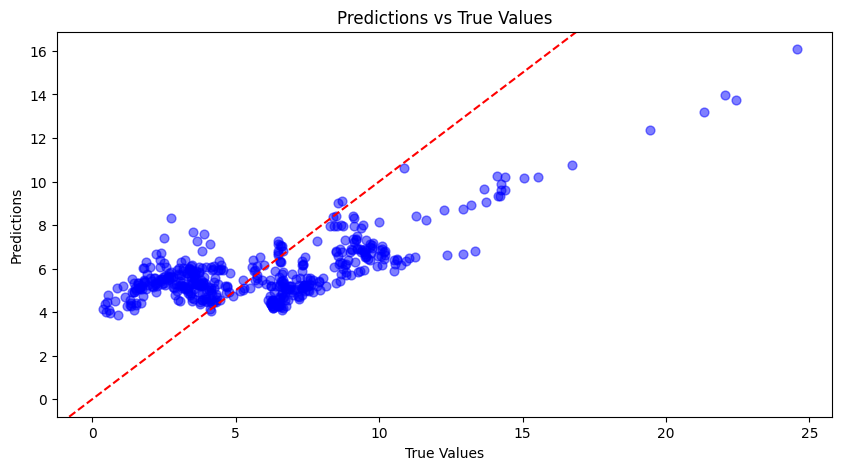

In [27]:
# plot the true vs predicted values
plt.figure(figsize=(10, 5))
plt.scatter(y_test_fit, predictions['mean'], c='b', s=40, alpha=0.5)
plt.axline([0, 0], [1, 1], color='red', linestyle='--')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title(f'Predictions vs True Values')
plt.show()

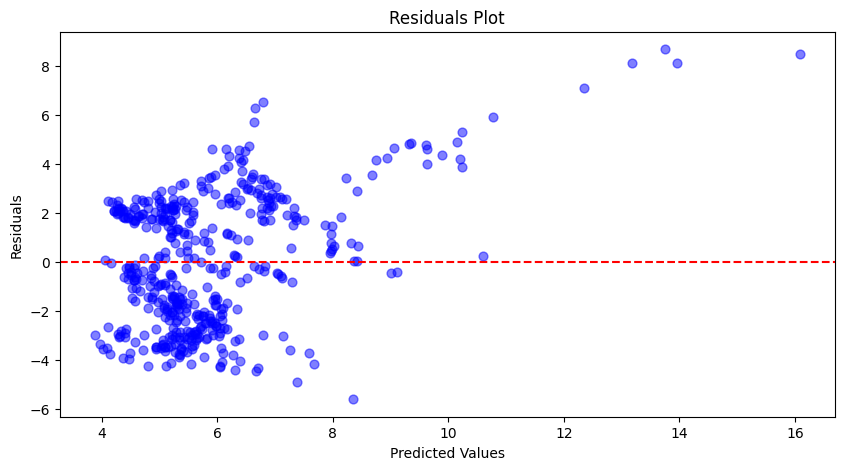

In [28]:
# plot the residuals 
residuals = y_test_fit['Absorbance 254nm'] - predictions['mean']
plt.figure(figsize=(10, 5))
plt.scatter(predictions['mean'], residuals, c='b', s=40, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.show()

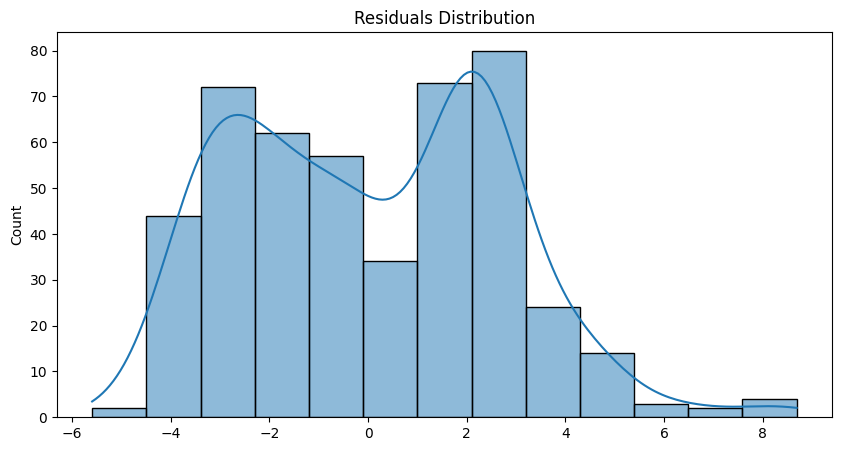

In [29]:
# plot the distribution of the residuals
plt.figure(figsize=(10, 5))
sns.histplot(residuals, kde=True)
plt.title('Residuals Distribution')
plt.show()

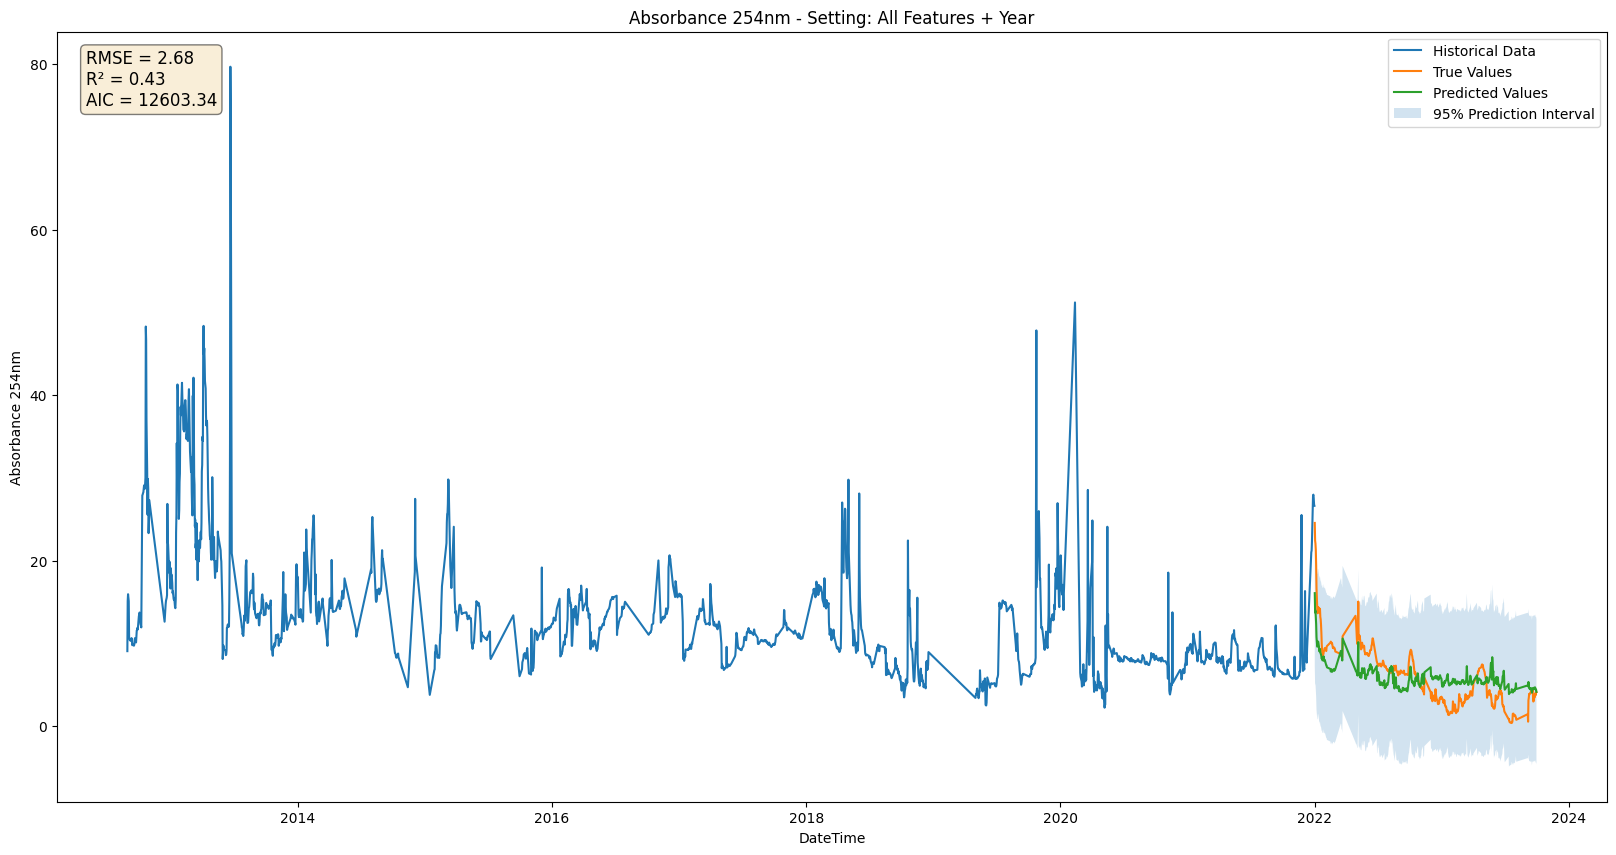

In [30]:
plt.figure(figsize=(20, 10))
sns.lineplot(x=y_train['DateTime'], y=y_train['Absorbance 254nm'], label='Historical Data')
# sns.lineplot(x=y_train['DateTime'], y=model.fittedvalues.values, label='Fitted Values')
sns.lineplot(x=y_test['DateTime'], y=y_test['Absorbance 254nm'], label='True Values')
sns.lineplot(x=y_test['DateTime'], y=predictions['mean'], label='Predicted Values')
plt.fill_between(y_test['DateTime'], predictions['obs_ci_lower'], predictions['obs_ci_upper'], alpha=0.2, label='95% Prediction Interval')
plt.xlabel('DateTime')
plt.ylabel('Absorbance 254nm')

# add rmse and r2 to the plot in a box
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

text_string = '\n'.join((
    f'RMSE = {rmse:.2f}',
    f'R\u00b2 = {r2:.2f}',
    f'AIC = {model.aic:.2f}',
))

plt.text(y_train['DateTime'].iloc[0] - pd.Timedelta(days=120), 75, s=text_string, fontsize=12, bbox=props)

plt.title(f'Absorbance 254nm - Setting: {setting}')

plt.legend()
plt.show()

### Store Results

In [31]:
lr_pred = predictions['mean']
lr_lower_bound = predictions['obs_ci_lower']
lr_upper_bound = predictions['obs_ci_upper']
lr_rmse = rmse
lr_r2 = r2

## Remove Features with p-value > 0.05

They are:

* Air Temperature
* Conductivity
* Daily Cumulated Rainfall
* Dissolved Oxygen
* Nitrate
* Water Temperature
* pH

In [32]:
setting = 'Ammonium + Flow River + Redox Potential + Turbidity + Year'

### Split Data

In [33]:
X = full_df[full_df.columns.difference(['Absorbance 254nm', 'Season', 'Month', 'Timestamp', 'Air Temperature', 'Daily Cumulated Rainfall', 'Nitrate', 'Dissolved Oxygen', 'Water Temperature', 'pH', 'Conductivity'])]

y = full_df[['DateTime','Absorbance 254nm']]

In [34]:
# split data such that 2022 and 2023 are test data
X_train = X[X['DateTime'] < '2022-01-01']
X_test = X[X['DateTime'] >= '2022-01-01']

y_train = y[y['DateTime'] < '2022-01-01']
y_test = y[y['DateTime'] >= '2022-01-01']

In [35]:
X_train_fit = X_train[X_train.columns.difference(['DateTime'])]
X_test_fit = X_test[X_test.columns.difference(['DateTime'])]

y_train_fit = y_train[y_train.columns.difference(['DateTime'])]
y_test_fit = y_test[y_test.columns.difference(['DateTime'])]

### Train Model

In [36]:
model = sm.OLS(y_train_fit, sm.add_constant(X_train_fit)).fit()

In [37]:
results = model.summary2()

### Results

In [38]:
print(results)

                   Results: Ordinary least squares
Model:               OLS               Adj. R-squared:      0.595     
Dependent Variable:  Absorbance 254nm  AIC:                 12619.1607
Date:                2024-03-14 01:57  BIC:                 12653.2307
No. Observations:    2161              Log-Likelihood:      -6303.6   
Df Model:            5                 F-statistic:         635.0     
Df Residuals:        2155              Prob (F-statistic):  0.00      
R-squared:           0.596             Scale:               20.062    
----------------------------------------------------------------------
                  Coef.   Std.Err.    t     P>|t|    [0.025    0.975] 
----------------------------------------------------------------------
const           2222.5016  73.6915  30.1595 0.0000 2077.9877 2367.0156
Ammonium          15.8245   2.9345   5.3926 0.0000   10.0698   21.5792
Flow River         0.0034   0.0004   8.2855 0.0000    0.0026    0.0042
Redox Potential   -0.0358 

### Predictions

In [39]:
# predict the model
predictions = model.get_prediction(sm.add_constant(X_test_fit)).summary_frame(alpha=0.05)

In [40]:
predictions

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
3412,14.547489,0.384115,13.794214,15.300764,5.731412,23.363566
3413,12.252610,0.338098,11.589579,12.915642,3.443785,21.061436
3414,12.531600,0.315612,11.912665,13.150535,3.725984,21.337216
3415,11.885313,0.286655,11.323165,12.447462,3.083507,20.687120
3416,11.063857,0.267439,10.539391,11.588323,2.264376,19.863337
...,...,...,...,...,...,...
4045,5.130392,0.330665,4.481937,5.778848,-3.677348,13.938133
4046,5.026768,0.331550,4.376577,5.676959,-3.781100,13.834636
4047,4.914225,0.328095,4.270808,5.557641,-3.893146,13.721596
4048,5.005406,0.321938,4.374064,5.636749,-3.801090,13.811903


### Plots

In [41]:
rmse = np.sqrt(mean_squared_error(y_test_fit, predictions['mean']))
r2 = r2_score(y_test_fit, predictions['mean'])

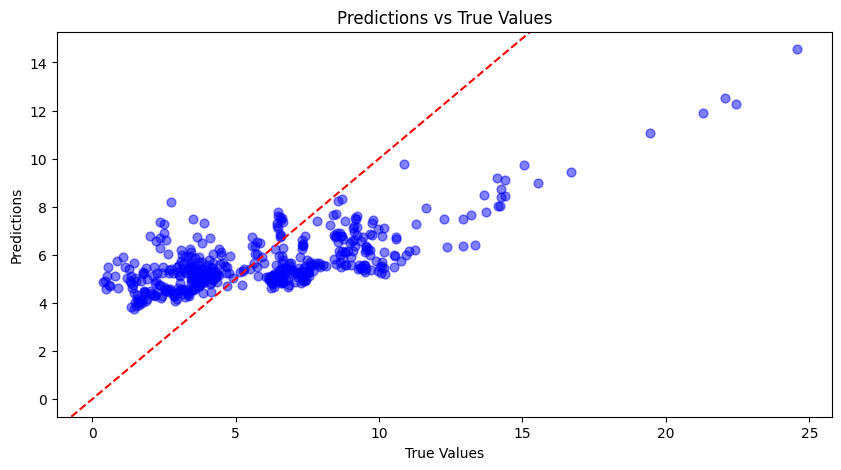

In [42]:
# plot the true vs predicted values
plt.figure(figsize=(10, 5))
plt.scatter(y_test_fit, predictions['mean'], c='b', s=40, alpha=0.5)
plt.axline([0, 0], [1, 1], color='red', linestyle='--')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title(f'Predictions vs True Values')
plt.show()

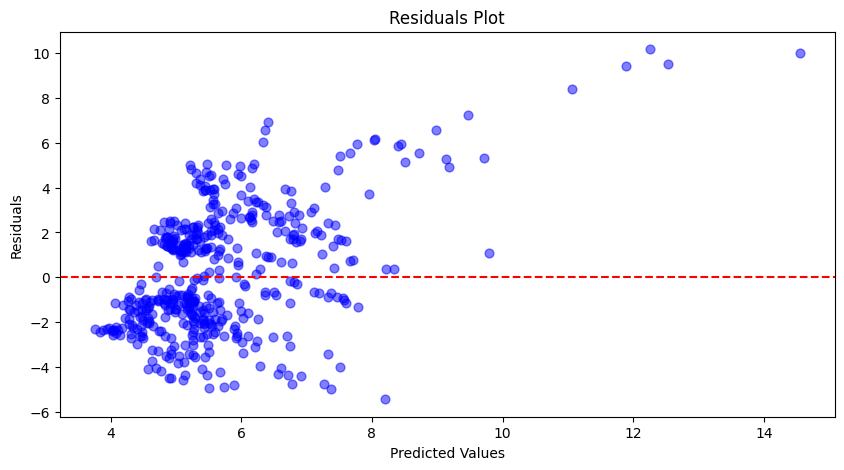

In [43]:
# plot the residuals 
residuals = y_test_fit['Absorbance 254nm'] - predictions['mean']
plt.figure(figsize=(10, 5))
plt.scatter(predictions['mean'], residuals, c='b', s=40, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.show()

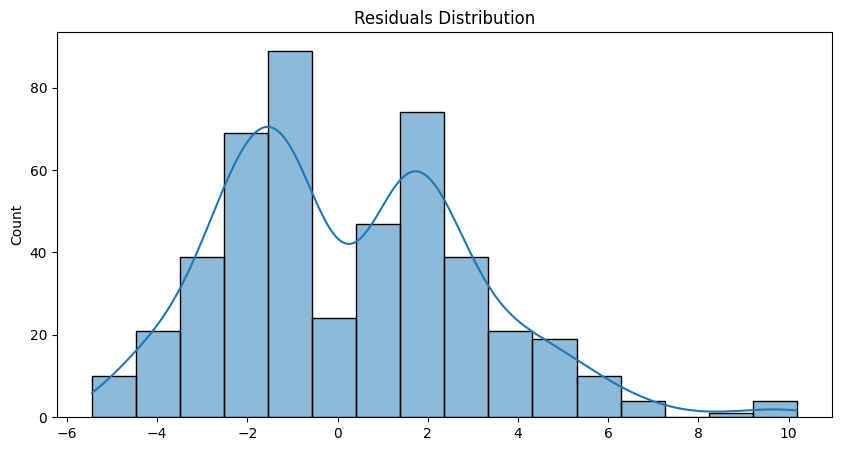

In [44]:
# plot the distribution of the residuals
plt.figure(figsize=(10, 5))
sns.histplot(residuals, kde=True)
plt.title('Residuals Distribution')
plt.show()

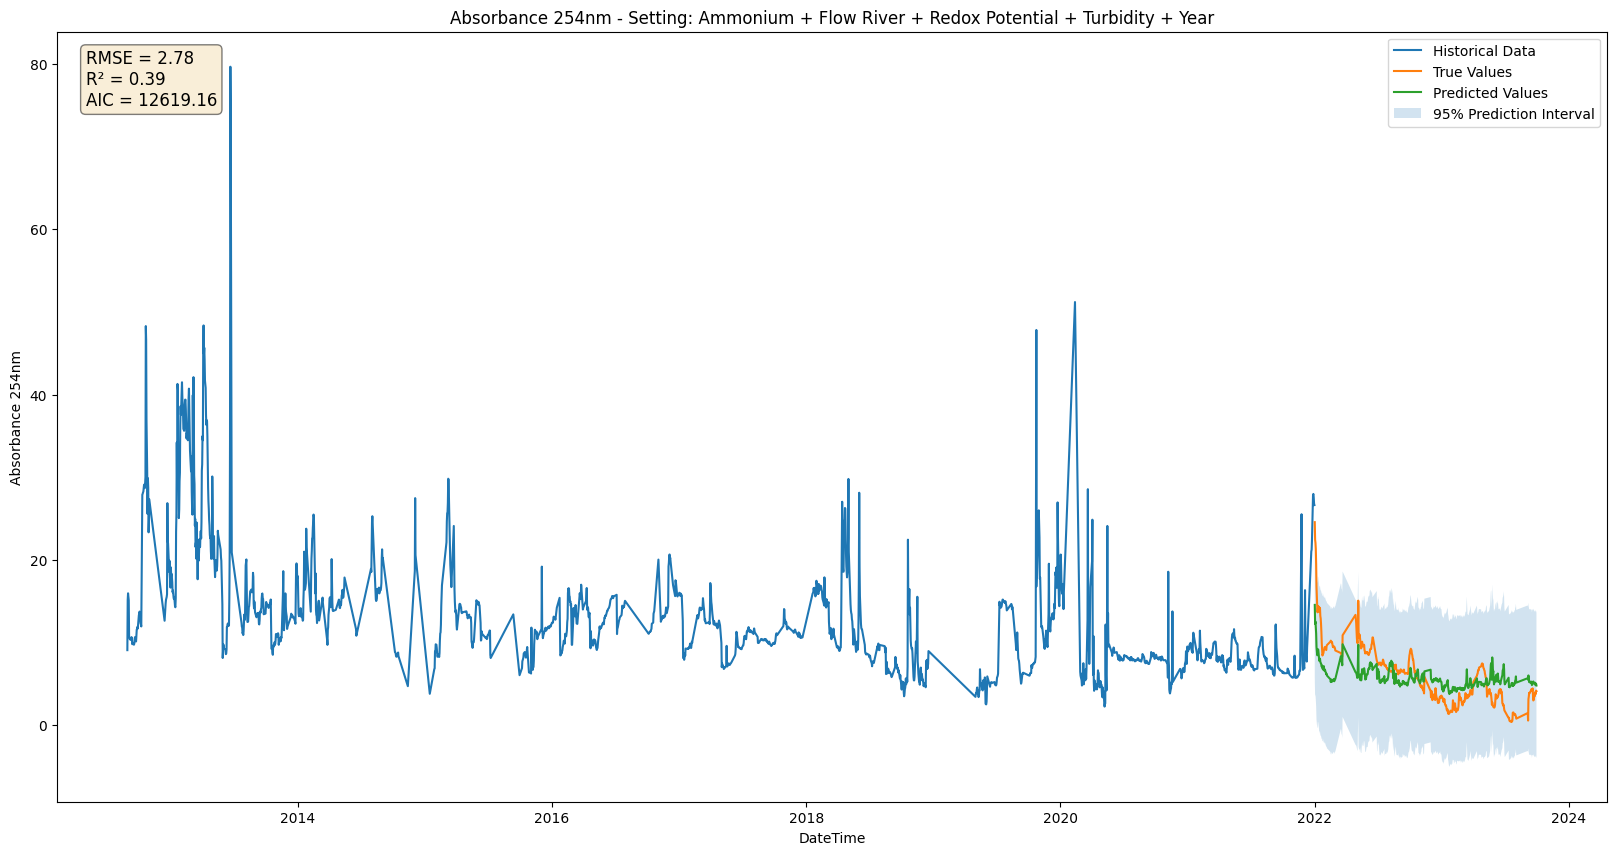

In [45]:
plt.figure(figsize=(20, 10))
sns.lineplot(x=y_train['DateTime'], y=y_train['Absorbance 254nm'], label='Historical Data')
sns.lineplot(x=y_test['DateTime'], y=y_test['Absorbance 254nm'], label='True Values')
sns.lineplot(x=y_test['DateTime'], y=predictions['mean'], label='Predicted Values')
plt.fill_between(y_test['DateTime'], predictions['obs_ci_lower'], predictions['obs_ci_upper'], alpha=0.2, label='95% Prediction Interval')
plt.xlabel('DateTime')
plt.ylabel('Absorbance 254nm')

# add rmse and r2 to the plot in a box
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

text_string = '\n'.join((
    f'RMSE = {rmse:.2f}',
    f'R\u00b2 = {r2:.2f}',
    f'AIC = {model.aic:.2f}',
))

plt.text(y_train['DateTime'].iloc[0] - pd.Timedelta(days=120), 75, s=text_string, fontsize=12, bbox=props)

plt.title(f'Absorbance 254nm - Setting: {setting}')

plt.legend()
plt.show()

# Random Forest

In [46]:
setting = 'All Features + Year'

### Split Data

In [47]:
X = full_df[full_df.columns.difference(['Absorbance 254nm', 'Season', 'Month', 'Timestamp', 'Year'])]

y = full_df[['DateTime','Absorbance 254nm']]

In [48]:
# split data such that 2022 and 2023 are test data
X_train = X[X['DateTime'] < '2022-01-01']
X_test = X[X['DateTime'] >= '2022-01-01']

y_train = y[y['DateTime'] < '2022-01-01']
y_test = y[y['DateTime'] >= '2022-01-01']

In [49]:
X_train_fit = X_train[X_train.columns.difference(['DateTime'])]
X_test_fit = X_test[X_test.columns.difference(['DateTime'])]

y_train_fit = y_train[y_train.columns.difference(['DateTime'])]
y_test_fit = y_test[y_test.columns.difference(['DateTime'])]

In [50]:
scaler = StandardScaler()
X_train_fit = scaler.fit_transform(X_train_fit)
X_test_fit = scaler.transform(X_test_fit)

### Train Model

#### Perform K-Fold Cross-Validation

K = 10 since the training set is composed of 10 years (almost).

In [51]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold

In [52]:
rf_model = RandomForestQuantileRegressor(n_estimators=20, max_features='log2', max_depth=7, random_state=42)

cv = KFold(n_splits=10)

rf_ensemble = cross_validate(rf_model, X_train_fit, y_train_fit.values.flatten(), cv=cv, scoring='neg_mean_squared_error', return_estimator=True, return_train_score=True)

In [53]:
scores_df = pd.DataFrame(rf_ensemble)
scores_df

,fit_time,score_time,estimator,test_score,train_score
0,0.054681,0.001231,"(DecisionTreeRegressor(max_depth=7, max_featur...",-191.005799,-6.257772
1,0.048915,0.001145,"(DecisionTreeRegressor(max_depth=7, max_featur...",-40.074467,-7.249317
2,0.048830,0.001390,"(DecisionTreeRegressor(max_depth=7, max_featur...",-33.782971,-6.376520
3,0.049349,0.001044,"(DecisionTreeRegressor(max_depth=7, max_featur...",-13.098551,-7.830247
4,0.050283,0.001002,"(DecisionTreeRegressor(max_depth=7, max_featur...",-14.624856,-8.000900
5,0.049131,0.001122,"(DecisionTreeRegressor(max_depth=7, max_featur...",-30.467319,-7.749437
6,0.049123,0.000978,"(DecisionTreeRegressor(max_depth=7, max_featur...",-17.178870,-7.350775
7,0.049469,0.001140,"(DecisionTreeRegressor(max_depth=7, max_featur...",-35.402205,-5.632085
8,0.048975,0.001097,"(DecisionTreeRegressor(max_depth=7, max_featur...",-8.725535,-7.206505
9,0.050359,0.001026,"(DecisionTreeRegressor(max_depth=7, max_featur...",-9.563576,-7.740784


### Results

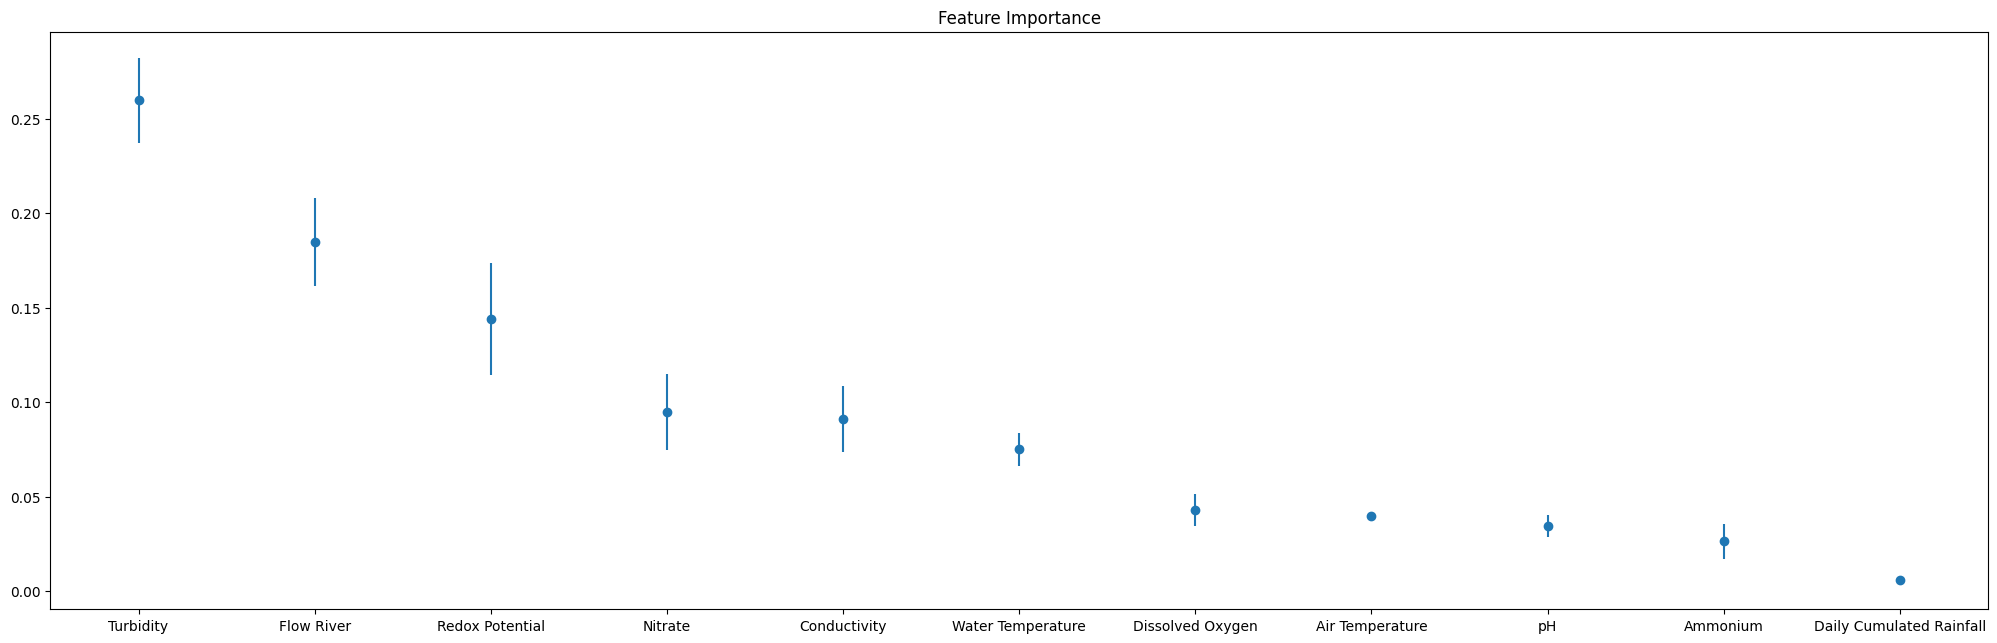

In [54]:
# show the importance of each feature in the model
feature_importance = pd.DataFrame()
feature_importance['feature'] = X_train.columns.difference(['DateTime'])
feature_importance['importance_mean'] = np.mean([estimator.feature_importances_ for estimator in rf_ensemble['estimator']], axis=0)
feature_importance['importance_std'] = np.std([estimator.feature_importances_ for estimator in rf_ensemble['estimator']], axis=0)

feature_importance = feature_importance.sort_values(by='importance_mean', ascending=False)

# plot the importance of each feature with the std
plt.figure(figsize=(25, 7.5))
plt.errorbar(x=feature_importance['feature'], y=feature_importance['importance_mean'], yerr=feature_importance['importance_std'], fmt='o')
plt.title('Feature Importance')
plt.show()

### Predictions

In [55]:
# get predictions
mean_predictions = np.array([estimator.predict(X_test_fit, quantiles=0.5) for estimator in rf_ensemble['estimator']])
lower_bound_predictions = np.array([estimator.predict(X_test_fit, quantiles=0.05) for estimator in rf_ensemble['estimator']])
upper_bound_predictions = np.array([estimator.predict(X_test_fit, quantiles=0.95) for estimator in rf_ensemble['estimator']])

In [56]:
mean_predictions = np.mean(mean_predictions, axis=0)
lower_bound_predictions = np.mean(lower_bound_predictions, axis=0)
upper_bound_predictions = np.mean(upper_bound_predictions, axis=0)

In [57]:
%%script false --no-raise-error
# try with best single model
best_model = rf_ensemble['estimator'][3]

mean_predictions = best_model.predict(X_test_fit, quantiles=0.5)
lower_bound_predictions = best_model.predict(X_test_fit, quantiles=0.05)
upper_bound_predictions = best_model.predict(X_test_fit, quantiles=0.95)

In [58]:
rmse = np.sqrt(mean_squared_error(y_test_fit, mean_predictions))
r2 = r2_score(y_test_fit, mean_predictions)

print(f'RMSE: {rmse:.2f}')
print(f'R\u00b2: {r2:.2f}')

RMSE: 6.40
R²: -2.24


### Plots

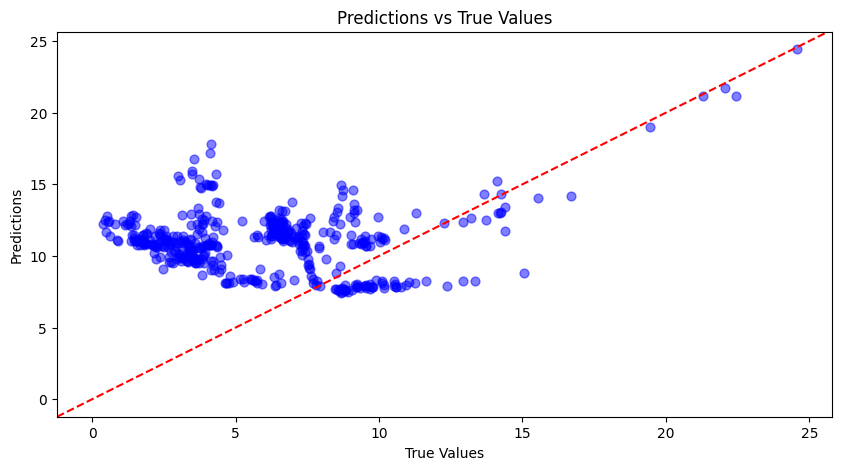

In [59]:
# plot the true vs predicted values
plt.figure(figsize=(10, 5))
plt.scatter(y_test_fit.values, mean_predictions, c='b', s=40, alpha=0.5)
plt.axline([0, 0], [1, 1], color='red', linestyle='--')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title(f'Predictions vs True Values')
plt.show()

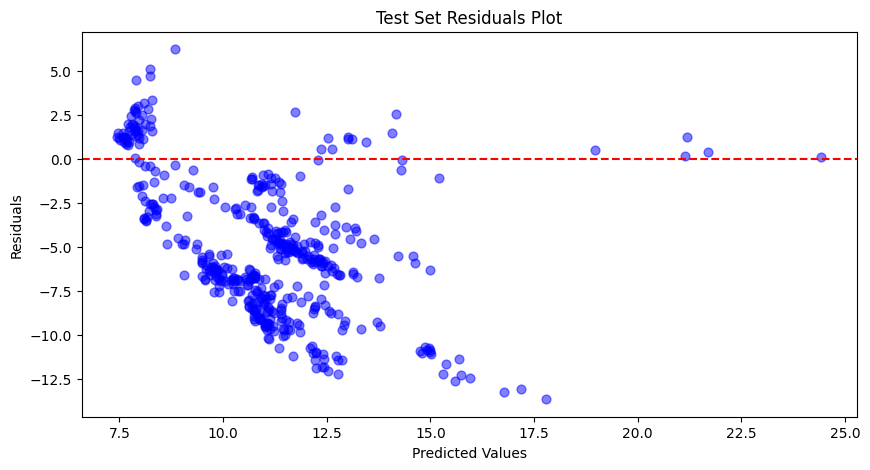

In [60]:
# plot the residuals 
residuals = y_test_fit['Absorbance 254nm'] - mean_predictions
plt.figure(figsize=(10, 5))
plt.scatter(mean_predictions, residuals, c='b', s=40, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Test Set Residuals Plot')
plt.show()

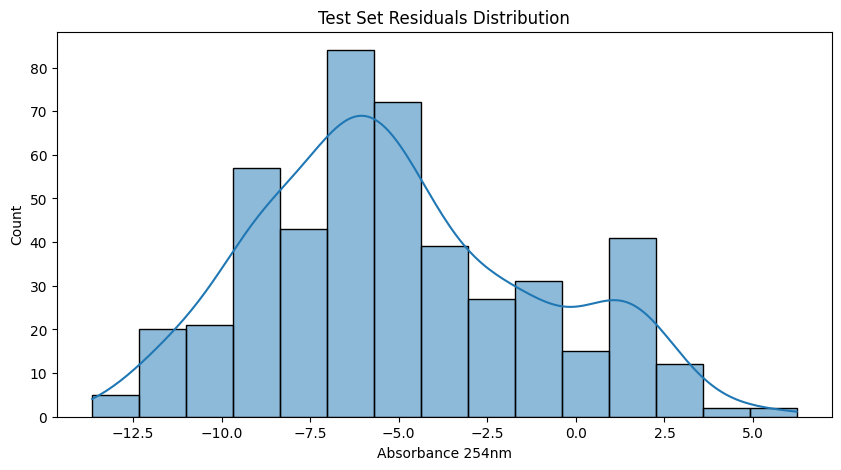

In [61]:
# plot the distribution of the residuals
plt.figure(figsize=(10, 5))
sns.histplot(residuals, kde=True)
plt.title('Test Set Residuals Distribution')
plt.show()

In [62]:
# get training residuals
train_predictions = np.array([estimator.predict(X_train_fit, quantiles=0.5) for estimator in rf_ensemble['estimator']])
train_predictions = np.mean(train_predictions, axis=0)

train_residuals = y_train_fit['Absorbance 254nm'] - train_predictions

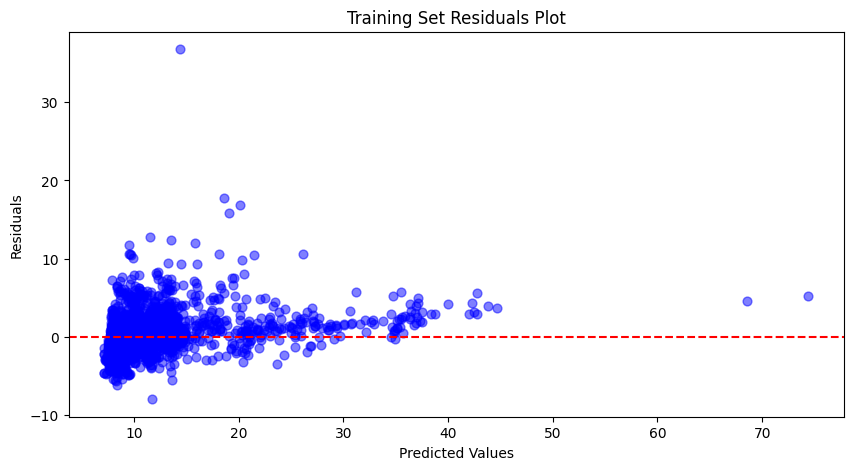

In [63]:
# plot the training residuals
plt.figure(figsize=(10, 5))
plt.scatter(train_predictions, train_residuals, c='b', s=40, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Training Set Residuals Plot')
plt.show()

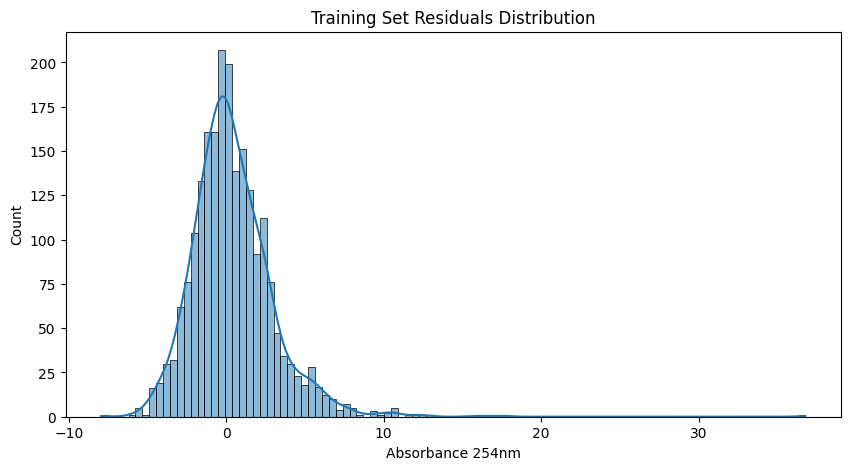

In [64]:
# plot the distribution of the training residuals
plt.figure(figsize=(10, 5))
sns.histplot(train_residuals, kde=True)
plt.title('Training Set Residuals Distribution')
plt.show()

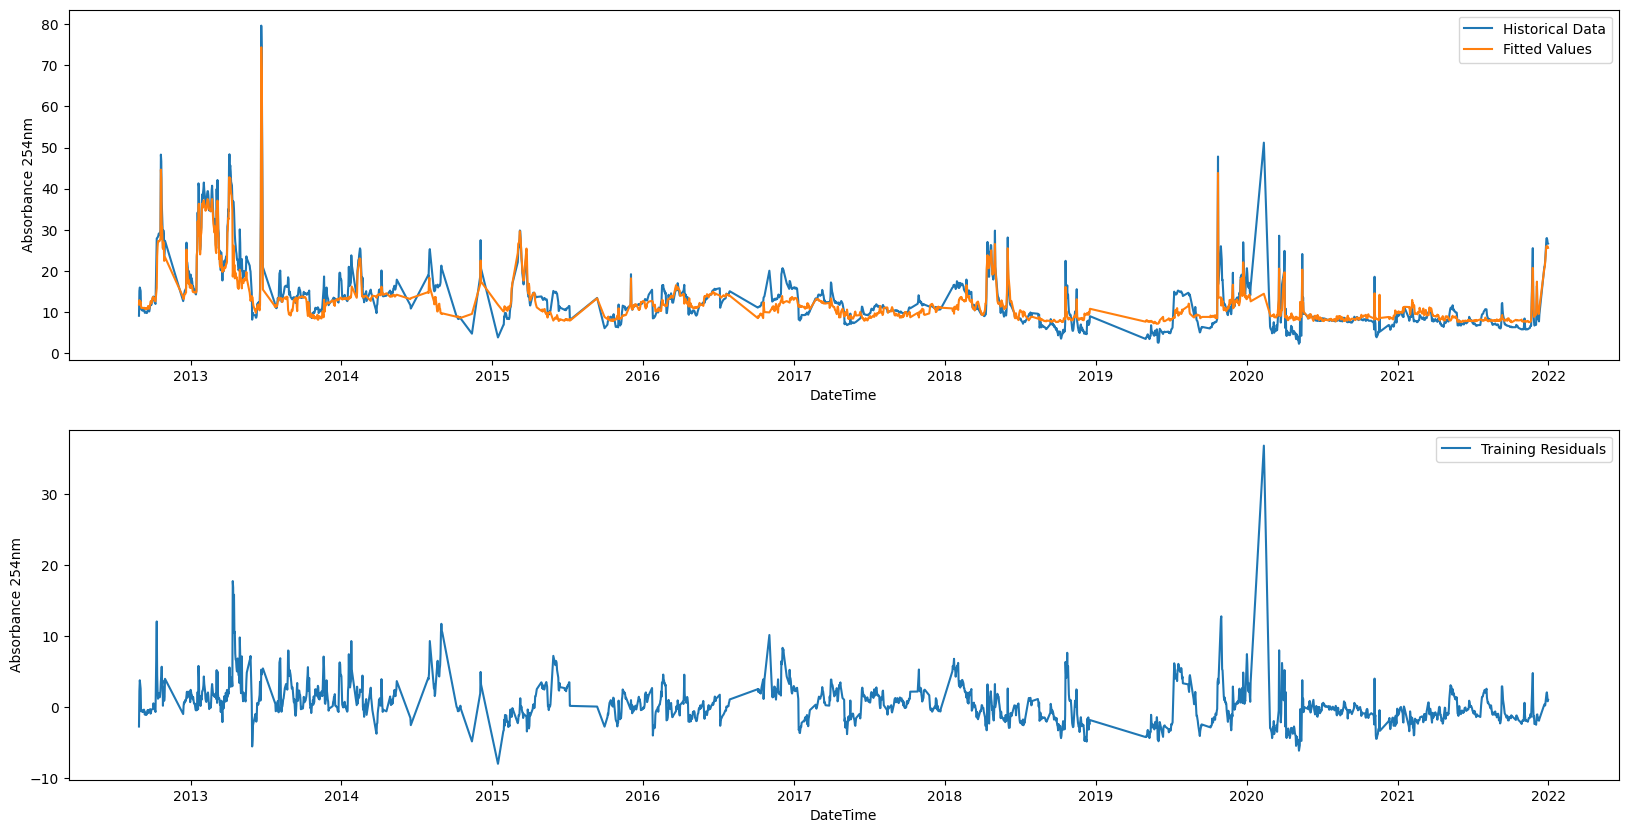

In [65]:
# plot the time series of the residuals and of the train set
fig, ax = plt.subplots(2, 1, figsize=(20, 10))
sns.lineplot(x=y_train['DateTime'], y=y_train['Absorbance 254nm'], label='Historical Data', ax=ax[0])
sns.lineplot(x=y_train['DateTime'], y=train_predictions, label='Fitted Values', ax=ax[0])   

sns.lineplot(x=y_train['DateTime'], y=train_residuals, label='Training Residuals' , ax=ax[1])

plt.show()


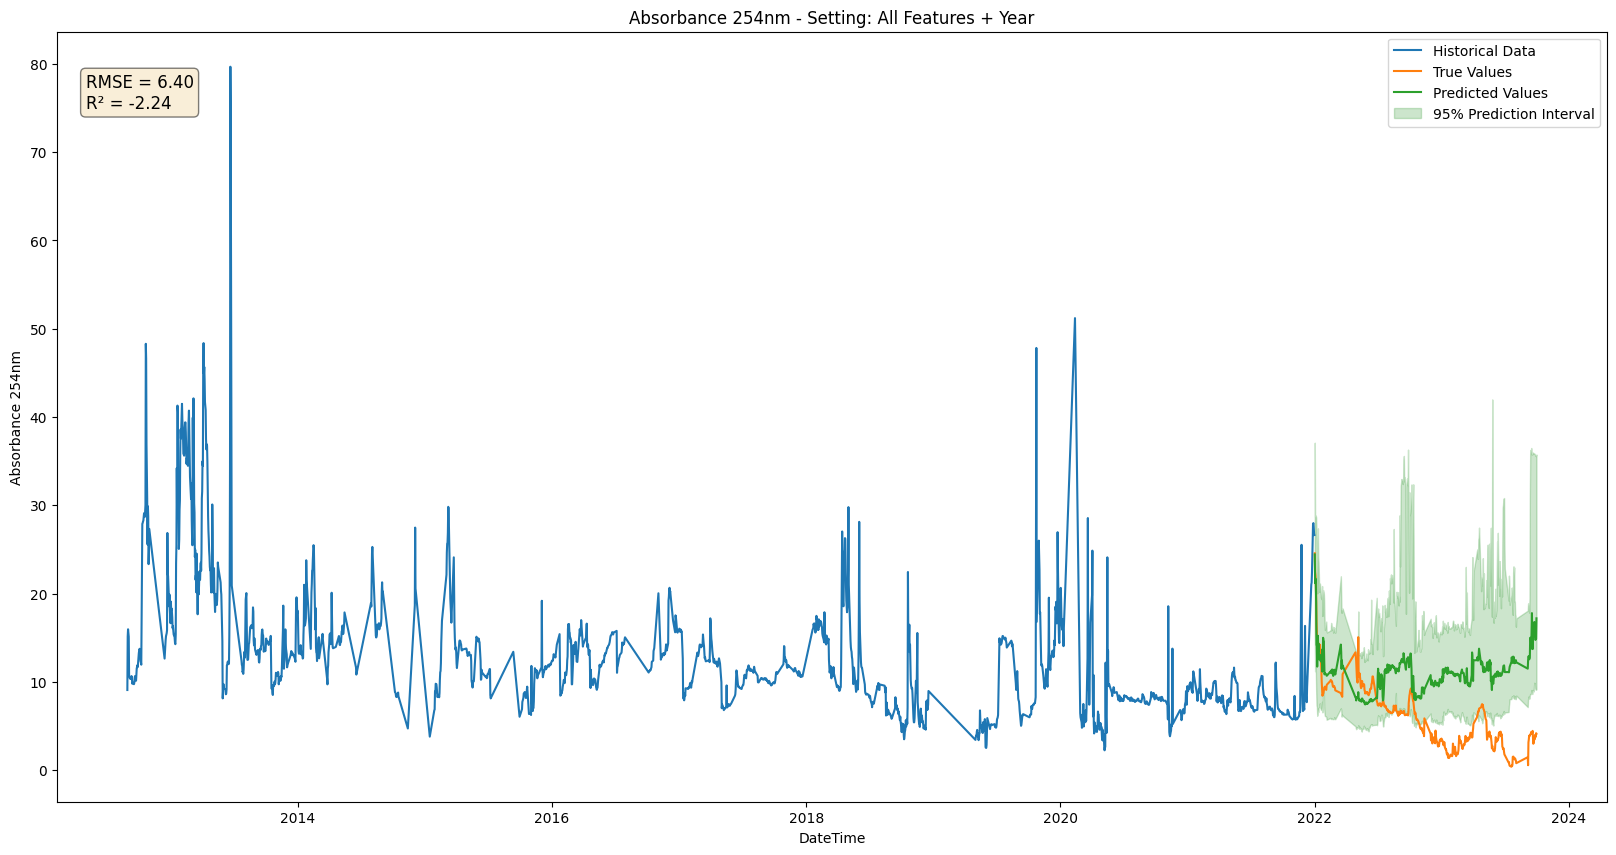

In [66]:
plt.figure(figsize=(20, 10))
sns.lineplot(x=y_train['DateTime'], y=y_train['Absorbance 254nm'], label='Historical Data')
sns.lineplot(x=y_test['DateTime'], y=y_test['Absorbance 254nm'], label='True Values')
sns.lineplot(x=y_test['DateTime'], y=mean_predictions, label='Predicted Values')
# plot std of predictions
plt.fill_between(y_test['DateTime'], lower_bound_predictions, y2=upper_bound_predictions, alpha=0.2, label='95% Prediction Interval', color='g')
plt.xlabel('DateTime')
plt.ylabel('Absorbance 254nm')

# add rmse and r2 to the plot in a box
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

text_string = '\n'.join((
    f'RMSE = {rmse:.2f}',
    f'R\u00b2 = {r2:.2f}',
))

plt.text(y_train['DateTime'].iloc[0] - pd.Timedelta(days=120), 75, s=text_string, fontsize=12, bbox=props)

plt.title(f'Absorbance 254nm - Setting: {setting}')

plt.legend()
plt.show()

Comment: prevede un trend crescente, probabilmente dato da qualche feature 

### Store Results

In [67]:
rf_pred = mean_predictions
rf_lower_bound = lower_bound_predictions
rf_upper_bound = upper_bound_predictions
rf_rmse = rmse
rf_r2 = r2

# Neural Network

In [68]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredLogarithmicError

## Split Data

In [69]:
def scale_datasets(x_train, x_test):

  """
  Standard Scale test and train data
  Z - Score normalization
  """
  standard_scaler = StandardScaler()
  x_train_scaled = pd.DataFrame(
      standard_scaler.fit_transform(x_train),
      columns=x_train.columns
  )
  x_test_scaled = pd.DataFrame(
      standard_scaler.transform(x_test),
      columns = x_test.columns
  )
  return x_train_scaled, x_test_scaled

In [70]:
X = full_df[full_df.columns.difference(['Absorbance 254nm', 'Season', 'Month', 'Timestamp'])]

y = full_df[['DateTime','Absorbance 254nm']]

In [71]:
# split data such that 2022 and 2023 are test data
X_train = X[X['DateTime'] < '2022-01-01']
X_test = X[X['DateTime'] >= '2022-01-01']

y_train = y[y['DateTime'] < '2022-01-01']
y_test = y[y['DateTime'] >= '2022-01-01']

In [72]:
X_train_fit = X_train[X_train.columns.difference(['DateTime'])]
X_test_fit = X_test[X_test.columns.difference(['DateTime'])]

y_train_fit = y_train[y_train.columns.difference(['DateTime'])]
y_test_fit = y_test[y_test.columns.difference(['DateTime'])]

In [73]:
X_train_scaled, X_test_scaled = scale_datasets(X_train_fit, X_test_fit)

## Define the model

In [74]:
# define and fit the model
def fit_model(X_train, y_train):
    # define neural network model
    features = X_train.shape[1]
    model = Sequential()
    model.add(Dense(10, kernel_initializer='he_normal', activation='relu', input_dim=features))
    model.add(Dense(1))
    # compile the model and specify loss and optimizer
    opt = Adam(learning_rate=0.01, beta_1=0.85, beta_2=0.999)
    model.compile(optimizer=opt, loss='mse')
    # fit the model on the training dataset
    model.fit(X_train, y_train, verbose=0, epochs=300, batch_size=16)
    return model

In [75]:
# fit an ensemble of models
def fit_ensemble(n_members, X_train, X_test, y_train, y_test):
    ensemble = list()
    for i in range(n_members):
    # define and fit the model on the training set
        model = fit_model(X_train, y_train)
        # evaluate model on the test set
        yhat = model.predict(X_test, verbose=0)
        rmse = np.sqrt(mean_squared_error(y_test, yhat))
        print('>%d, RMSE: %.3f' % (i+1, rmse))
        # store the model
        ensemble.append(model)
    return ensemble

In [76]:
def get_errors(ensemble, X_train, y_train):
    errors = list()
    for model in ensemble:
        yhat = model.predict(X_train, verbose=0)
        error = np.sqrt(mean_squared_error(y_train, yhat))
        errors.append(error)
    return errors

In [77]:
# make predictions with the ensemble and calculate a prediction interval
def predict_with_pi(ensemble, X):
    # make predictions
    yhat = [model.predict(X, verbose=0) for model in ensemble]
    yhat = np.asarray(yhat)
    yhat = yhat.reshape(yhat.shape[0], yhat.shape[1])
    # calculate 95% gaussian prediction interval
    stds = np.std(yhat, axis=0)
    interval = 1.96 * stds
    means = np.mean(yhat, axis=0)
    lower, upper = means - interval, means + interval
    return lower, means, upper

In [78]:
%%script false --no-raise-error
hidden_units1 = 160
hidden_units2 = 480
hidden_units3 = 256
learning_rate = 0.01
# Creating model using the Sequential in tensorflow
def build_model_using_sequential():
  model = Sequential([
    Dense(hidden_units1, kernel_initializer='normal', activation='relu'),
    Dropout(0.2),
    Dense(hidden_units2, kernel_initializer='normal', activation='relu'),
    Dropout(0.2),
    Dense(hidden_units3, kernel_initializer='normal', activation='relu'),
    Dense(1, kernel_initializer='normal', activation='linear')
  ])
  return model

In [79]:
%%script false --no-raise-error
model = build_model_using_sequential()

In [80]:
%%script false --no-raise-error
# loss function
msle = MeanSquaredLogarithmicError()
model.compile(
    loss=msle, 
    optimizer=Adam(learning_rate=learning_rate), 
    metrics=[msle]
)

## Train the model

In [81]:
%%script false --no-raise-error
history = model.fit(
    X_train_scaled.values, 
    y_train_fit.values, 
    epochs=50, 
    batch_size=64,
    validation_split=0.2,
    verbose=1,
)

In [82]:
%%script false --no-raise-error
def plot_history(history, key):
  plt.plot(history.history[key])
  plt.plot(history.history['val_'+key])
  plt.xlabel("Epochs")
  plt.ylabel(key)
  plt.legend([key, 'val_'+key])
  plt.show()
# Plot the history
plot_history(history, 'mean_squared_logarithmic_error')

In [83]:
n_members = 10

ensemble = fit_ensemble(
    n_members,
    X_train_scaled.values,
    X_test_scaled.values,
    y_train_fit.values,
    y_test_fit.values
)

/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


>1, RMSE: 4.558


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


>2, RMSE: 7.361


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


>3, RMSE: 4.934


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


>4, RMSE: 3.775


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


>5, RMSE: 4.745


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


>6, RMSE: 5.152


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


>7, RMSE: 5.096


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


>8, RMSE: 5.259


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


>9, RMSE: 5.084


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


>10, RMSE: 4.862


In [84]:
train_rmses = get_errors(ensemble, X_train_scaled.values, y_train_fit.values)

In [85]:
train_rmses

[2.8065529834675282,
 2.8414461676398375,
 2.8078205804442518,
 2.7620418751317093,
 3.0121860449353224,
 2.741094864905808,
 2.673158338928589,
 3.06329302966494,
 2.7360311754597633,
 2.8353602119388177]

## Prediction

In [86]:
%%script false --no-raise-error
y_pred = model.predict(X_test_scaled)

In [87]:
(lower_bound, y_pred, upper_bound) = predict_with_pi(ensemble, X_test_scaled)

## Plots

In [88]:
rmse = np.sqrt(mean_squared_error(y_test_fit, y_pred))
r2 = r2_score(y_test_fit, y_pred)

print(f'RMSE: {rmse:.2f}')
print(f'R\u00b2: {r2:.2f}')

RMSE: 4.29
R²: -0.45


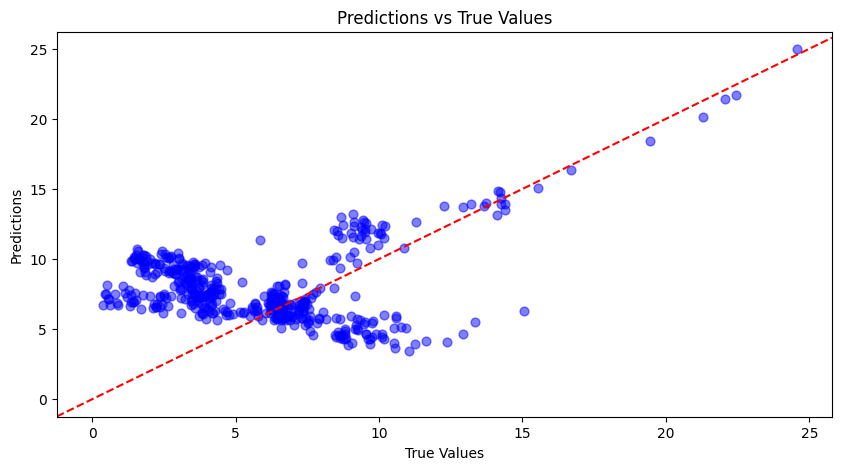

In [89]:
# plot the true vs predicted values
plt.figure(figsize=(10, 5))
plt.scatter(y_test_fit, y_pred, c='b', s=40, alpha=0.5)
plt.axline([0, 0], [1, 1], color='red', linestyle='--')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title(f'Predictions vs True Values')
plt.show()

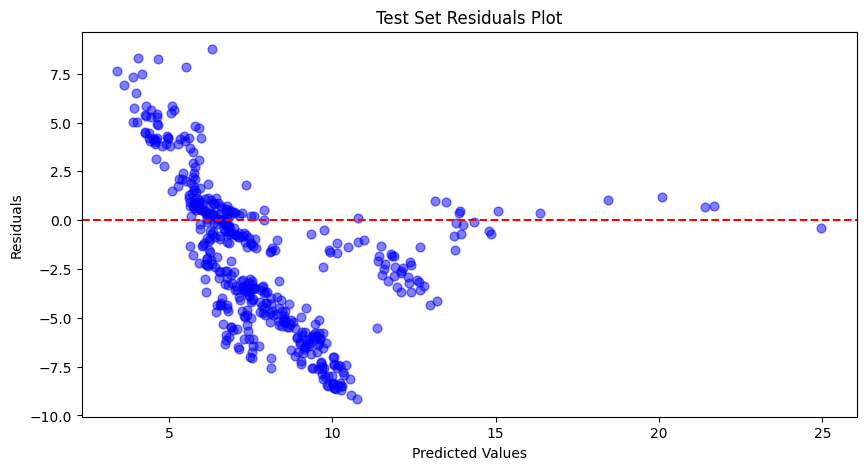

In [90]:
# plot the residuals 
residuals = y_test_fit['Absorbance 254nm'] - y_pred.flatten()
plt.figure(figsize=(10, 5))
plt.scatter(y_pred.flatten(), residuals, c='b', s=40, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Test Set Residuals Plot')
plt.show()

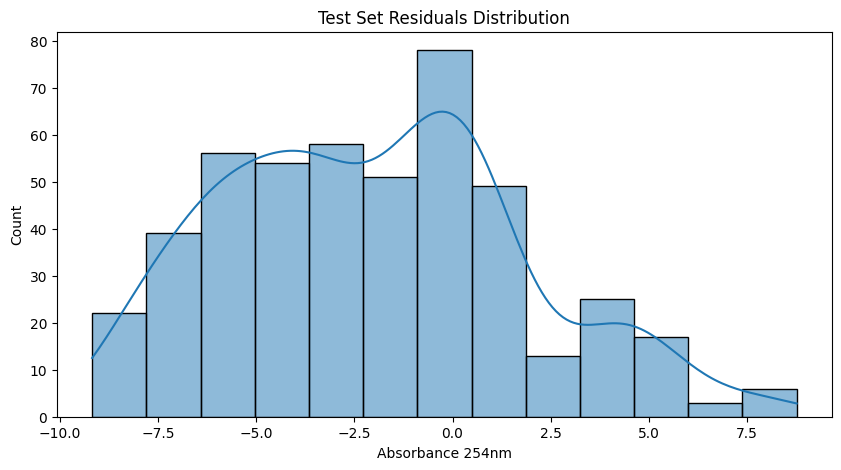

In [91]:
# plot the distribution of the residuals
plt.figure(figsize=(10, 5))
sns.histplot(residuals, kde=True)
plt.title('Test Set Residuals Distribution')
plt.show()

In [92]:
# get training residuals
(_, train_predictions, _) = predict_with_pi(ensemble, X_train_scaled)
train_residuals = y_train_fit['Absorbance 254nm'] - train_predictions

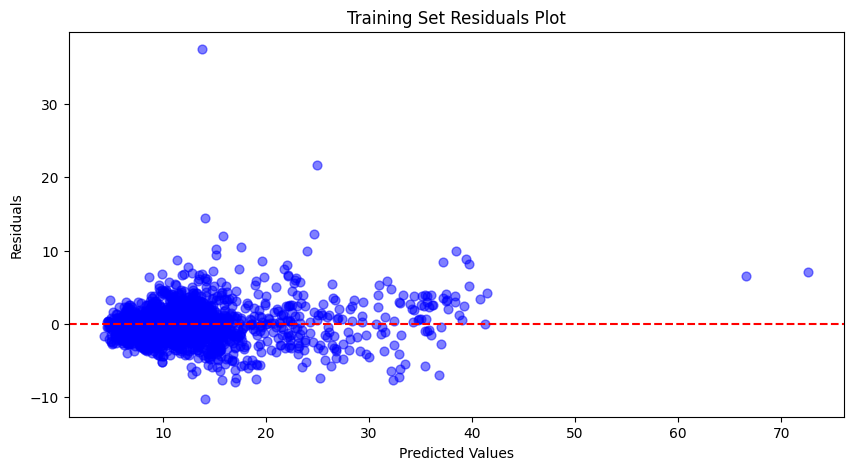

In [93]:
# plot the training residuals
plt.figure(figsize=(10, 5))
plt.scatter(train_predictions.flatten(), train_residuals, c='b', s=40, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Training Set Residuals Plot')
plt.show()

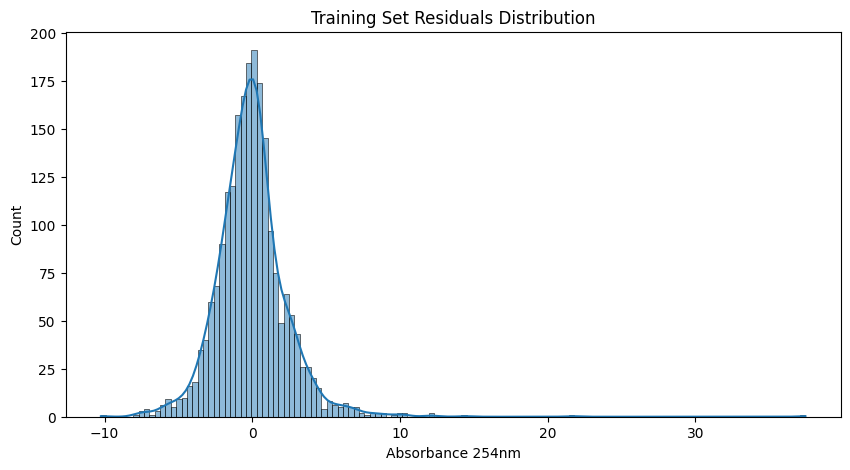

In [94]:
# plot the distribution of the training residuals
plt.figure(figsize=(10, 5))
sns.histplot(train_residuals, kde=True)
plt.title('Training Set Residuals Distribution')
plt.show()

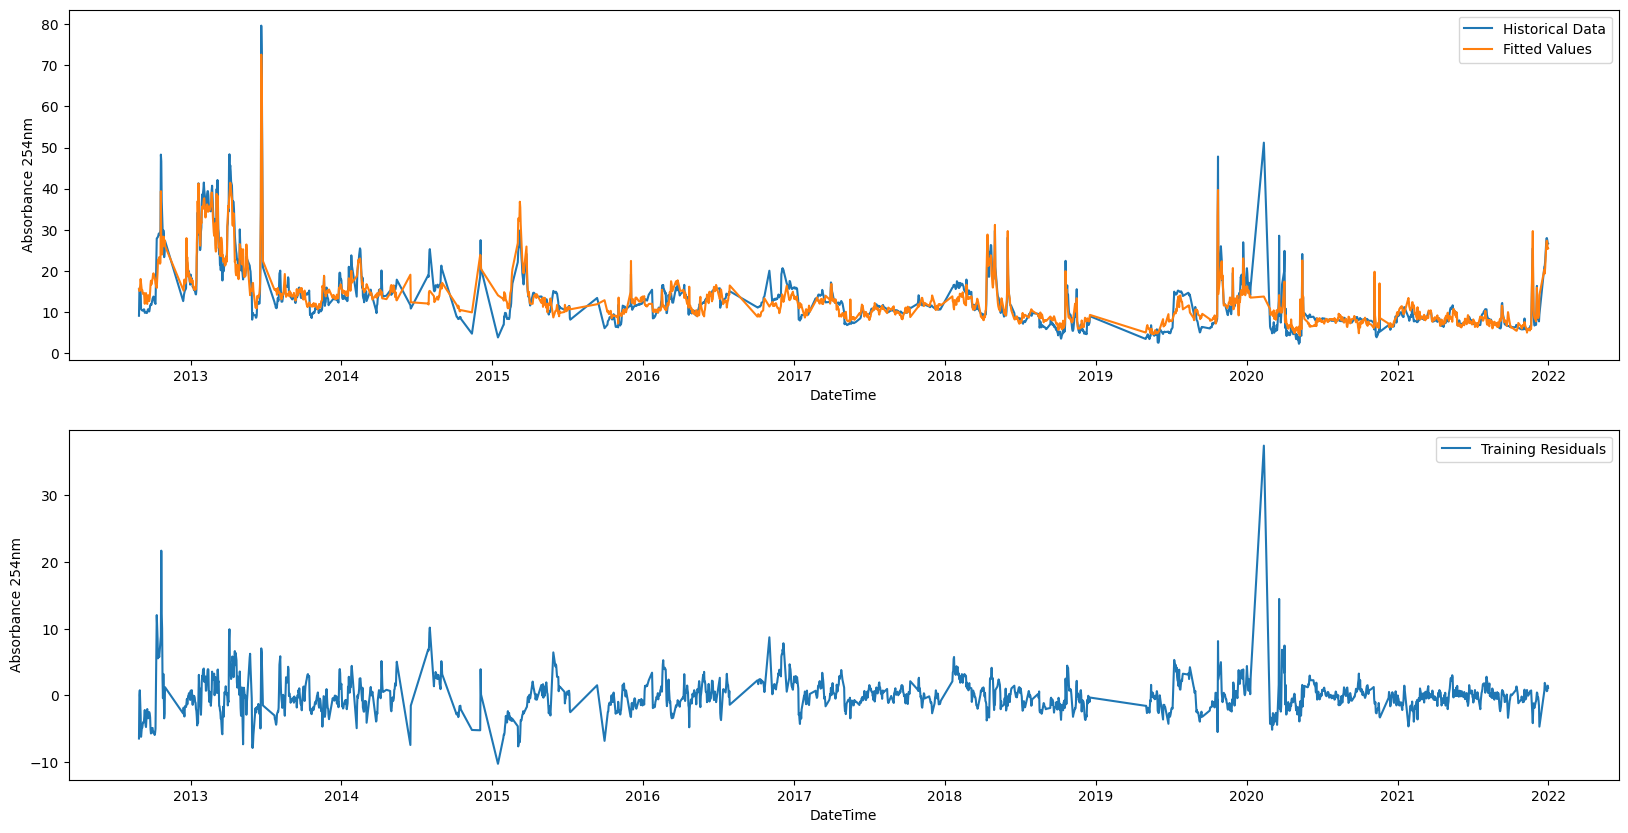

In [95]:
# plot the time series of the residuals and of the train set
fig, ax = plt.subplots(2, 1, figsize=(20, 10))
sns.lineplot(x=y_train['DateTime'], y=y_train['Absorbance 254nm'], label='Historical Data', ax=ax[0])
sns.lineplot(x=y_train['DateTime'], y=train_predictions, label='Fitted Values', ax=ax[0])   

sns.lineplot(x=y_train['DateTime'], y=train_residuals, label='Training Residuals' , ax=ax[1])

plt.show()

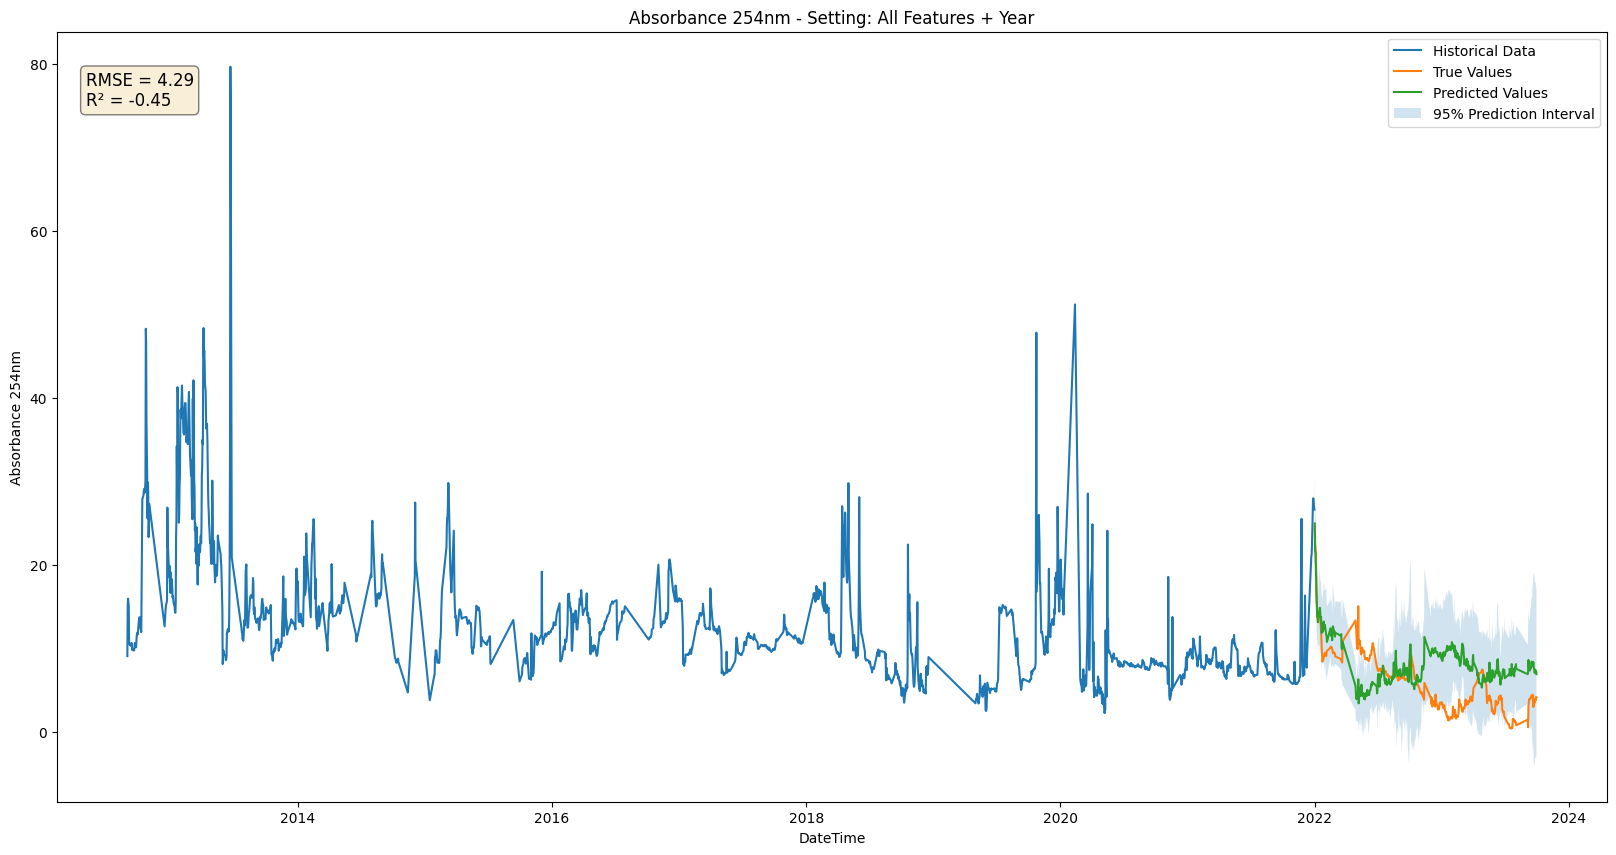

In [96]:
plt.figure(figsize=(20, 10))
sns.lineplot(x=y_train['DateTime'], y=y_train['Absorbance 254nm'], label='Historical Data')
sns.lineplot(x=y_test['DateTime'], y=y_test['Absorbance 254nm'], label='True Values')
sns.lineplot(x=y_test['DateTime'], y=y_pred, label='Predicted Values')
plt.fill_between(y_test['DateTime'], lower_bound, upper_bound, alpha=0.2, label='95% Prediction Interval')
plt.xlabel('DateTime')
plt.ylabel('Absorbance 254nm')

# add rmse and r2 to the plot in a box
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

text_string = '\n'.join((
    f'RMSE = {rmse:.2f}',
    f'R\u00b2 = {r2:.2f}',
))

plt.text(y_train['DateTime'].iloc[0] - pd.Timedelta(days=120), 75, s=text_string, fontsize=12, bbox=props)

plt.title(f'Absorbance 254nm - Setting: {setting}')

plt.legend()
plt.show()

## Store Results

In [97]:
nn_pred = y_pred
nn_lower_bound = lower_bound
nn_upper_bound = upper_bound
nn_rmse = rmse
nn_r2 = r2

# Final Plot

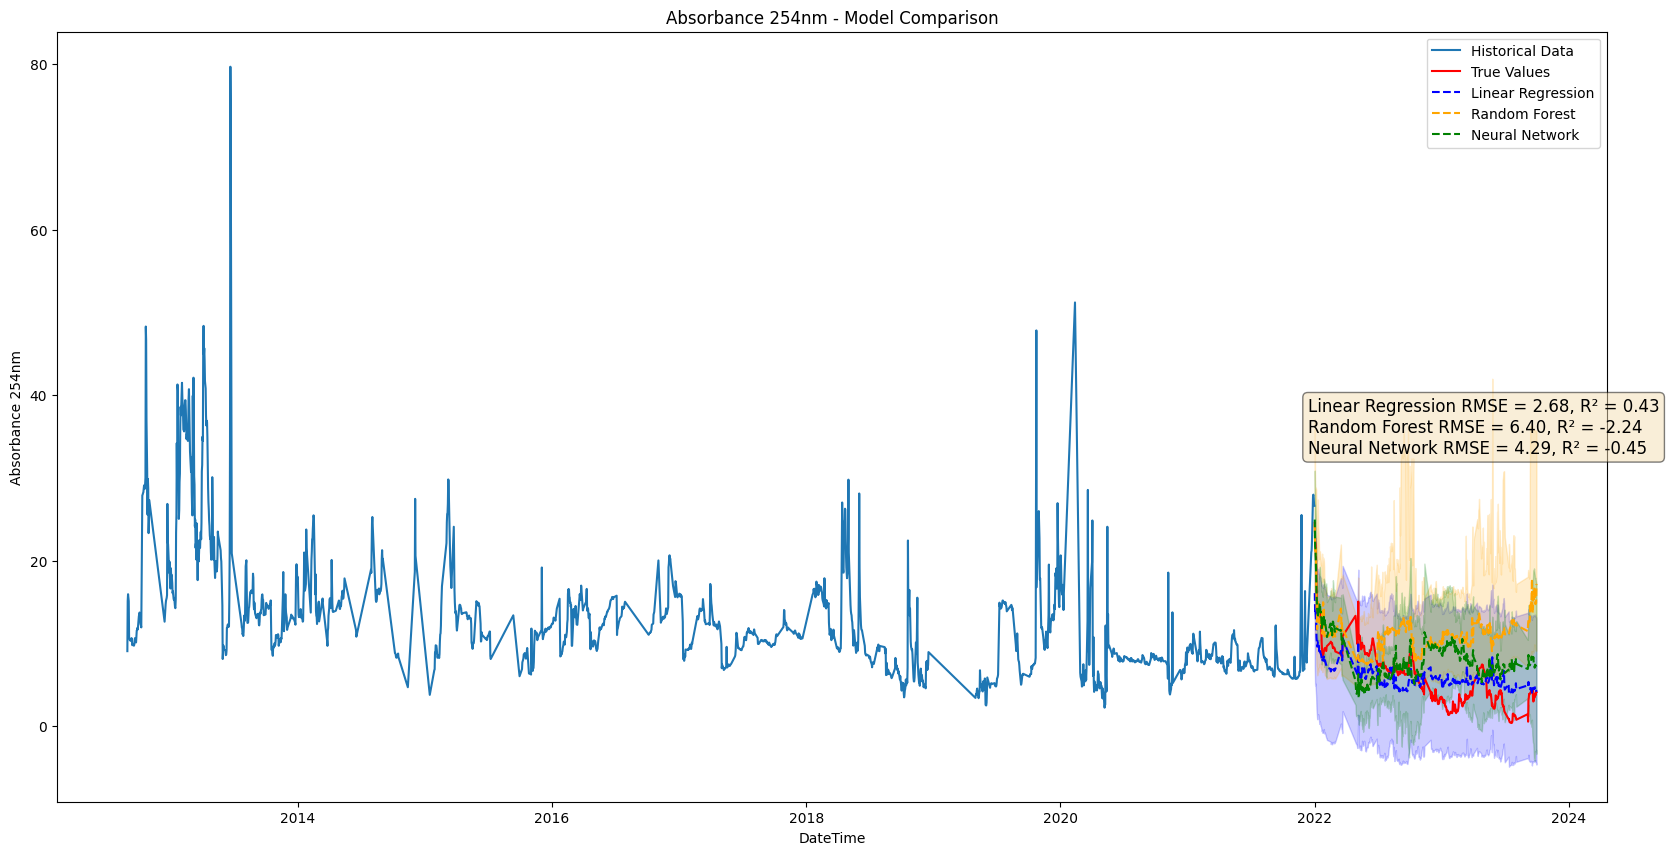

In [101]:
# create a plot for the comparison of the models
plt.figure(figsize=(20, 10))
sns.lineplot(x=y_train['DateTime'], y=y_train['Absorbance 254nm'], label='Historical Data')
sns.lineplot(x=y_test['DateTime'], y=y_test['Absorbance 254nm'], label='True Values', color='red')

# Linear Regression
sns.lineplot(x=y_test['DateTime'], y=lr_pred, label='Linear Regression', linestyle='--', color='blue')
plt.fill_between(y_test['DateTime'], lr_lower_bound, lr_upper_bound, alpha=0.2, color='blue')

# Random Forest
sns.lineplot(x=y_test['DateTime'], y=rf_pred, label='Random Forest', linestyle='--', color='orange')
plt.fill_between(y_test['DateTime'], rf_lower_bound, rf_upper_bound, alpha=0.2, color='orange')

# Neural Network
sns.lineplot(x=y_test['DateTime'], y=nn_pred, label='Neural Network', linestyle='--', color='green')
plt.fill_between(y_test['DateTime'], nn_lower_bound, nn_upper_bound, alpha=0.2, color='green')

plt.xlabel('DateTime')
plt.ylabel('Absorbance 254nm')

# add rmse and r2 to the plot in a box
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

text_string = '\n'.join((
    f'Linear Regression RMSE = {lr_rmse:.2f}, R\u00b2 = {lr_r2:.2f}',
    f'Random Forest RMSE = {rf_rmse:.2f}, R\u00b2 = {rf_r2:.2f}',
    f'Neural Network RMSE = {nn_rmse:.2f}, R\u00b2 = {nn_r2:.2f}',
))

plt.text(y_test['DateTime'].iloc[0] - pd.Timedelta(days=20), 33, s=text_string, fontsize=12, bbox=props)

plt.title(f'Absorbance 254nm - Model Comparison')

plt.legend()
plt.show()

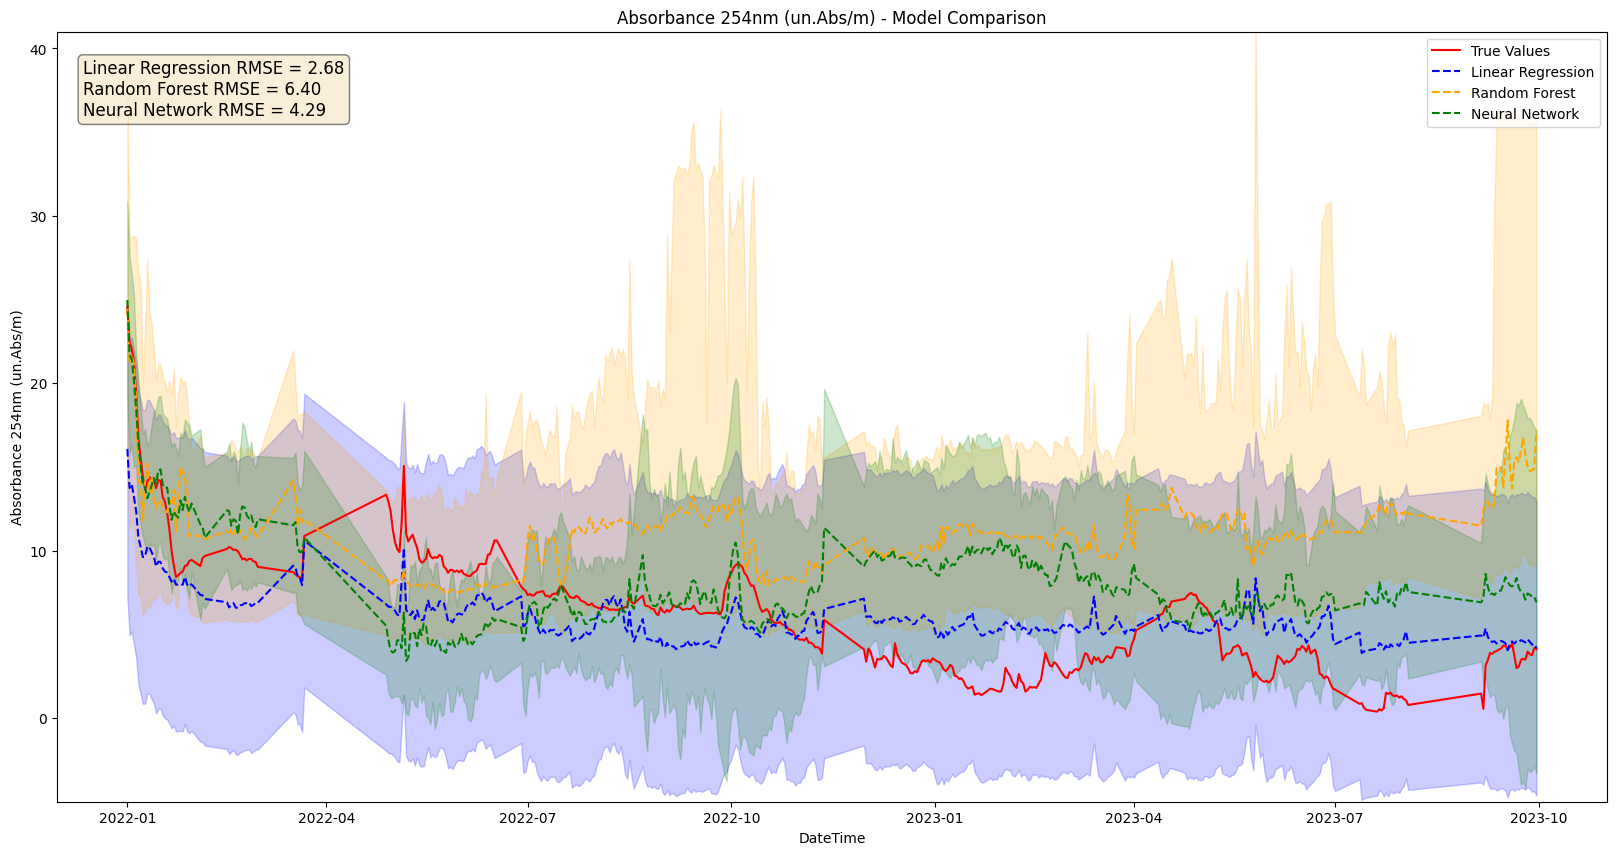

In [115]:
# create a plot for the comparison of the models
plt.figure(figsize=(20, 10))
# sns.lineplot(x=y_train['DateTime'], y=y_train['Absorbance 254nm'], label='Historical Data')
sns.lineplot(x=y_test['DateTime'], y=y_test['Absorbance 254nm'], label='True Values', color='red')

# Linear Regression
sns.lineplot(x=y_test['DateTime'], y=lr_pred, label='Linear Regression', linestyle='--', color='blue')
plt.fill_between(y_test['DateTime'], lr_lower_bound, lr_upper_bound, alpha=0.2, color='blue')

# Random Forest
sns.lineplot(x=y_test['DateTime'], y=rf_pred, label='Random Forest', linestyle='--', color='orange')
plt.fill_between(y_test['DateTime'], rf_lower_bound, rf_upper_bound, alpha=0.2, color='orange')

# Neural Network
sns.lineplot(x=y_test['DateTime'], y=nn_pred, label='Neural Network', linestyle='--', color='green')
plt.fill_between(y_test['DateTime'], nn_lower_bound, nn_upper_bound, alpha=0.2, color='green')

#change the y range to see the differences  
plt.ylim(-5, 41)

plt.xlabel('DateTime')
plt.ylabel('Absorbance 254nm (un.Abs/m)')

# add rmse and r2 to the plot in a box
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

text_string = '\n'.join((
    f'Linear Regression RMSE = {lr_rmse:.2f}',
    f'Random Forest RMSE = {rf_rmse:.2f}',
    f'Neural Network RMSE = {nn_rmse:.2f}',
))

plt.text(y_test['DateTime'].iloc[0] - pd.Timedelta(days=20), 36, s=text_string, fontsize=12, bbox=props)

plt.title(f'Absorbance 254nm (un.Abs/m) - Model Comparison')

plt.legend()
plt.show()